# 合并（子图+annotation） 到 原图
将多个子图+annotation合并到完整的原图片中

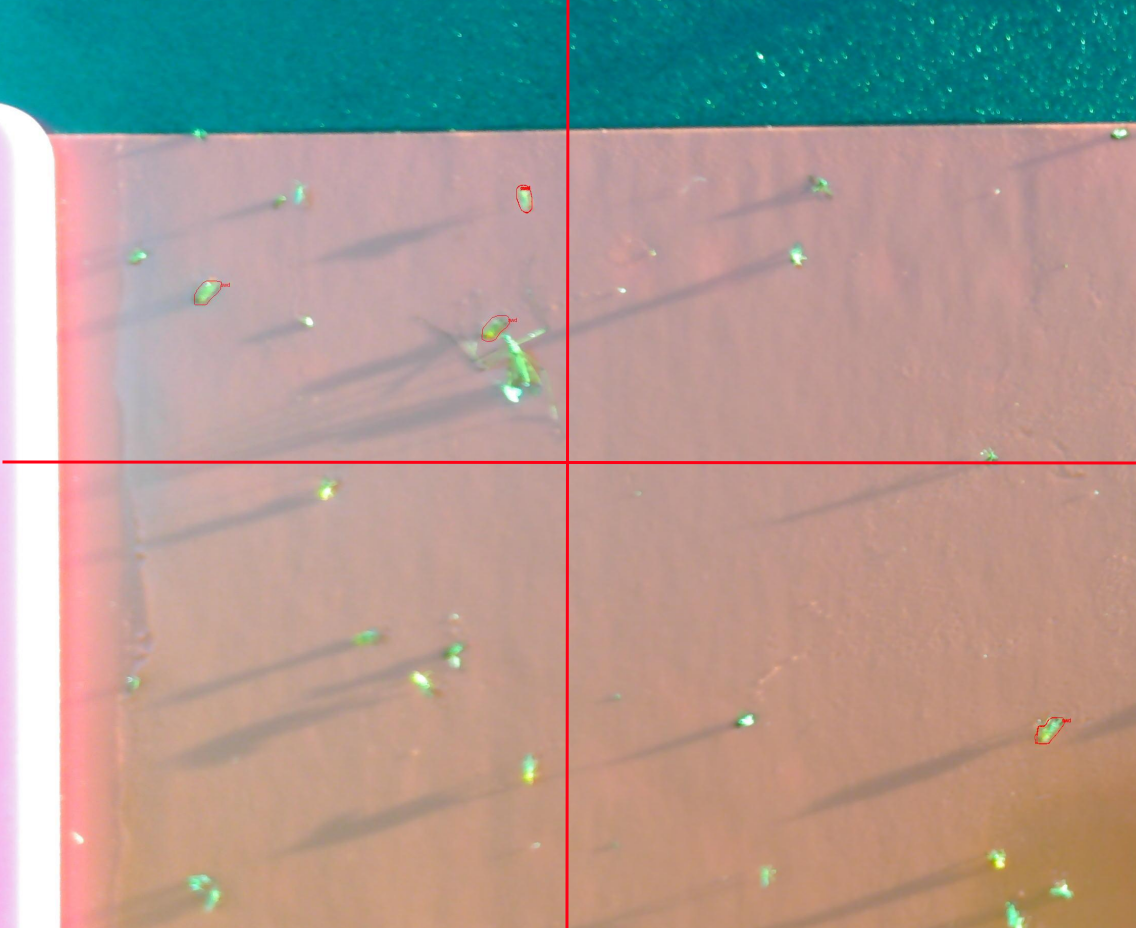

✅ 合并完成，共处理 173 张原图

✔️ 合并标注已保存到 rest_2024_images_sliced_merge/merged_annotations.json

🔁 重复目标已清理：5648 → 3716

1 --> ✔️ 清理过的合并标注已保存到 rest_2024_images_sliced_merge/merged_annotations.json, 覆盖原文件

2 --> 🖼 可视化图片已保存到 visualizations/

3 --> 📦 个体裁剪图像已保存到 rest_2024_images_sliced_merge/cropped_objects/  （总共3716张图。选了1000张标记。剩余的放到cropped_rest里了）

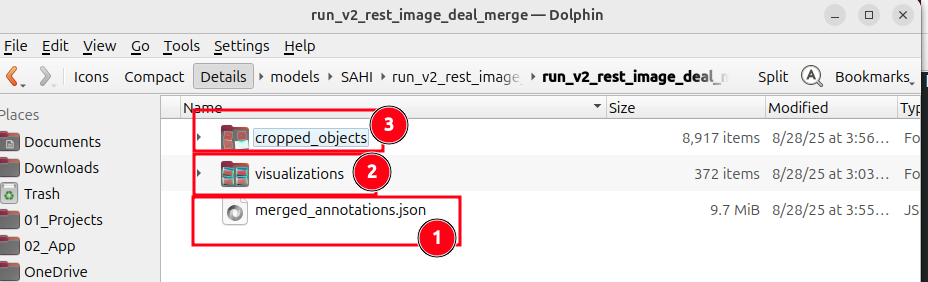


In [ ]:
import os
import json
from collections import defaultdict
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
import math
import uuid

try:
    from shapely.geometry import Polygon
    from shapely.ops import unary_union
    _HAVE_SHAPELY = True
except Exception:
    _HAVE_SHAPELY = False

def parse_filename(filename: str):
    """解析切片文件名获取原图名和偏移"""
    parts = Path(filename).stem.split("_")
    name = "_".join(parts[:-4])
    x1, y1, x2, y2 = map(int, parts[-4:])
    return name, x1, y1


def merge_annotations(sliced_label_dir, output_json_path):
    """
    合并所有切片的标注到原图坐标系，并保存为 JSON。
    返回合并后的 annotations 字典。
    """
    merged_annotations = defaultdict(list)

    for json_file in Path(sliced_label_dir).rglob("*.json"):
        with open(json_file, "r") as f:
            data = json.load(f)

        image_path = data["imagePath"]
        original_name, offset_x, offset_y = parse_filename(image_path)

        for shape in data["shapes"]:
            points = shape["points"]
            label = shape["label"]

            new_points = [[x + offset_x, y + offset_y] for x, y in points]

            object_uuid = str(uuid.uuid4())

            merged_annotations[original_name].append({
                "uuid": object_uuid,
                "original_name": original_name,
                "label": label,
                "points": new_points,
                "offset_x": offset_x,
                "offset_y": offset_y,
                "score": shape["score"],
            })


    with open(output_json_path, "w") as f:
        json.dump(merged_annotations, f, indent=2)

    print(f"✅ 合并完成，共处理 {len(merged_annotations)} 张原图")
    print(f"✔️ 合并标注已保存到 {output_json_path}")
    return merged_annotations


def remove_duplicate_annotations(
    merged_annotations,
    output_json_path,
    postprocess_type="GREEDYNMM",           # 'NMM' | 'GREEDYNMM' | 'LSNMS' | 'NMS'
    postprocess_match_metric="IOS",          # 'IOU' | 'IOS'
    postprocess_match_threshold=0.5,         # 触发合并/抑制的重叠度阈值
    postprocess_class_agnostic=False,        # True=忽略类别直接合并
    center_thresh=20,                        # 额外中心距离约束
    keep_mode="REP"                          # 'REP' 代表 polygon；'UNION_POLY' shapely并集（需要 shapely）
):
    """
    SAHI 风格后处理（score-aware） + 保留 polygon：
      - NMS：按 score 做抑制，只保留最高分 polygon
      - GREEDYNMM/NMM：score 贪心分组 -> 组内合并（REP 或 UNION_POLY）
      - LSNMS：类似 NMS，但代表选择采用分数优先 + 重叠度和近似局部最优
    """

    from collections import defaultdict

    # --------- 基础函数 ---------
    def polygon_to_bbox(points):
        xs, ys = zip(*points)
        return [min(xs), min(ys), max(xs), max(ys)]

    def bbox_area(b):
        return max(0, b[2]-b[0]) * max(0, b[3]-b[1])

    def bbox_iou(boxA, boxB):
        xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
        inter = max(0, xB-xA) * max(0, yB-yA)
        if inter <= 0: return 0.0
        u = bbox_area(boxA) + bbox_area(boxB) - inter
        return inter / u if u > 0 else 0.0

    def bbox_ios(boxA, boxB):
        xA = max(boxA[0], boxB[0]); yA = max(boxA[1], boxB[1])
        xB = min(boxA[2], boxB[2]); yB = min(boxA[3], boxB[3])
        inter = max(0, xB-xA) * max(0, yB-yA)
        if inter <= 0: return 0.0
        smaller = min(bbox_area(boxA), bbox_area(boxB))
        return inter / smaller if smaller > 0 else 0.0

    def center_distance(boxA, boxB):
        cxA = (boxA[0] + boxA[2]) / 2.0; cyA = (boxA[1] + boxA[3]) / 2.0
        cxB = (boxB[0] + boxB[2]) / 2.0; cyB = (boxB[1] + boxB[3]) / 2.0
        return math.hypot(cxA - cxB, cyA - cyB)

    def match_metric(boxA, boxB):
        return bbox_iou(boxA, boxB) if postprocess_match_metric.upper() == "IOU" else bbox_ios(boxA, boxB)

    def same_group(ann_i, ann_j):
        if (not postprocess_class_agnostic) and (ann_i["label"] != ann_j["label"]):
            return False
        bi = polygon_to_bbox(ann_i["points"])
        bj = polygon_to_bbox(ann_j["points"])
        if center_thresh is not None and center_distance(bi, bj) > center_thresh:
            return False
        return match_metric(bi, bj) >= postprocess_match_threshold

    # --------- 代表选择（score-aware） ---------
    def safe_score(a):
        s = a.get("score", None)
        try:
            return float(s) if s is not None else 0.0
        except Exception:
            return 0.0

    def choose_rep_polygon_by_score(grp):
        """
        代表 polygon：优先最高 score；若分数相同，用“与组内其它成员总重叠（IOU/IOS 之和）”打破平局
        """
        best = None
        best_key = (-1e9, -1e9)  # (score, overlap_sum)
        for i, ai in enumerate(grp):
            bi = polygon_to_bbox(ai["points"])
            overlap_sum = 0.0
            for j, aj in enumerate(grp):
                if i == j: continue
                bj = polygon_to_bbox(aj["points"])
                overlap_sum += match_metric(bi, bj)
            key = (safe_score(ai), overlap_sum)
            if key > best_key:
                best_key = key; best = ai
        rep = dict(best)
        rep["uuid"] = str(uuid.uuid4())
        return rep

    # --------- shapely 并集（可选） ---------
    def union_polygon(grp):
        if not _HAVE_SHAPELY:
            return choose_rep_polygon_by_score(grp)
        polys=[]
        for a in grp:
            pts = a["points"]
            if len(pts) >= 3:
                try:
                    polys.append(Polygon(pts))
                except Exception:
                    pass
        if not polys:
            return choose_rep_polygon_by_score(grp)
        merged = unary_union(polys)
        if merged.geom_type == "MultiPolygon":
            merged = max(list(merged.geoms), key=lambda p: p.area)
        xys = list(merged.exterior.coords)
        poly_points = [[float(x), float(y)] for (x,y) in xys[:-1]]
        base = dict(grp[0])
        base["uuid"] = str(uuid.uuid4())
        base["points"] = poly_points if len(poly_points) >= 3 else grp[0]["points"]
        # 代表分数（可选）：取组内最高分，便于后续可视化/排序
        base["score"] = max(safe_score(a) for a in grp)
        return base

    def merge_group(grp):
        return union_polygon(grp) if keep_mode.upper() == "UNION_POLY" else choose_rep_polygon_by_score(grp)

    # --------- NMS / GREEDYNMM / NMM / LSNMS 实现 ---------
    def nms_by_score(anns):
        """标准 NMS：按 score 降序，逐个选保留，抑制重叠框；输出保留的 polygon（代表就是选中的本体）"""
        anns_sorted = sorted(anns, key=lambda a: safe_score(a), reverse=True)
        keep = []
        for a in anns_sorted:
            suppress = False
            ba = polygon_to_bbox(a["points"])
            for b in keep:
                if not postprocess_class_agnostic and a["label"] != b["label"]:
                    continue
                bb = polygon_to_bbox(b["points"])
                if (center_thresh is None or center_distance(ba, bb) <= center_thresh) and \
                   match_metric(ba, bb) >= postprocess_match_threshold:
                    suppress = True; break
            if not suppress:
                keep.append(a)
        # 复制一份并刷新 uuid（不改 polygon）
        out = []
        for k in keep:
            kk = dict(k); kk["uuid"] = str(uuid.uuid4())
            out.append(kk)
        return out

    def greedy_group_by_score(anns):
        """GREEDY 分组（以 score 作为 seed 顺序）：seed 吸收与组内任一成员匹配的元素"""
        used = [False]*len(anns)
        order = sorted(range(len(anns)), key=lambda i: safe_score(anns[i]), reverse=True)
        groups=[]
        for idx in order:
            if used[idx]: continue
            seed = anns[idx]
            grp = [seed]; used[idx]=True
            changed = True
            while changed:
                changed = False
                for j, aj in enumerate(anns):
                    if used[j]: continue
                    if any(same_group(aj, g) for g in grp):
                        grp.append(aj); used[j]=True; changed=True
            groups.append(grp)
        return groups

    def pairwise_group(anns):
        """NMM 的朴素分组：两两扫描，把与 seed 匹配的并入"""
        used=[False]*len(anns); groups=[]
        order = sorted(range(len(anns)), key=lambda i: safe_score(anns[i]), reverse=True)
        for idx in order:
            if used[idx]: continue
            seed = anns[idx]
            grp=[seed]; used[idx]=True
            for j in order:
                if used[j]: continue
                if same_group(seed, anns[j]):
                    grp.append(anns[j]); used[j]=True
            groups.append(grp)
        return groups

    def lsnms_like(anns):
        """
        LSNMS 近似：按 score 排序做 NMS，但每加入一个保留元素时，
        在“当前组（被它抑制的元素）”里挑一个更好的代表（score 优先 + 重叠度和），
        以逼近局部最优；最后输出代表多边形。
        """
        anns_sorted = sorted(anns, key=lambda a: safe_score(a), reverse=True)
        kept_reps = []
        suppressed = [False]*len(anns_sorted)
        for i, ai in enumerate(anns_sorted):
            if suppressed[i]: continue
            # 找被 ai 抑制的集合（含 ai 自身）
            group = [ai]
            suppressed[i] = True
            bai = polygon_to_bbox(ai["points"])
            for j in range(i+1, len(anns_sorted)):
                if suppressed[j]: continue
                aj = anns_sorted[j]
                if (not postprocess_class_agnostic) and (ai["label"] != aj["label"]):
                    continue
                baj = polygon_to_bbox(aj["points"])
                if (center_thresh is None or center_distance(bai, baj) <= center_thresh) and \
                   match_metric(bai, baj) >= postprocess_match_threshold:
                    group.append(aj); suppressed[j] = True
            kept_reps.append(merge_group(group))  # 这里可用 REP/UNION_POLY
        return kept_reps

    cleaned_annotations = {}
    total_before = sum(len(v) for v in merged_annotations.values())
    total_after = 0

    for image_name, ann_list in merged_annotations.items():
        # 可选：先按类别分桶
        if not postprocess_class_agnostic:
            buckets = defaultdict(list)
            for a in ann_list:
                buckets[a["label"]].append(a)
            out_list=[]
            for _, bucket in buckets.items():
                t = postprocess_type.upper()
                if t == "NMS":
                    out_list.extend(nms_by_score(bucket))
                elif t == "NMM":
                    groups = pairwise_group(bucket)
                    out_list.extend([merge_group(g) for g in groups])
                elif t == "LSNMS":
                    out_list.extend(lsnms_like(bucket))
                else:  # GREEDYNMM（默认）
                    groups = greedy_group_by_score(bucket)
                    out_list.extend([merge_group(g) for g in groups])
        else:
            t = postprocess_type.upper()
            if t == "NMS":
                out_list = nms_by_score(ann_list)
            elif t == "NMM":
                groups = pairwise_group(ann_list)
                out_list = [merge_group(g) for g in groups]
            elif t == "LSNMS":
                out_list = lsnms_like(ann_list)
            else:
                groups = greedy_group_by_score(ann_list)
                out_list = [merge_group(g) for g in groups]

        cleaned_annotations[image_name] = out_list
        total_after += len(out_list)

    with open(output_json_path, "w") as f:
        json.dump(cleaned_annotations, f, indent=2)

    print(f"🔁 后处理完成（{postprocess_type}, metric={postprocess_match_metric}, thr={postprocess_match_threshold}, class_agnostic={postprocess_class_agnostic}, keep={keep_mode}）")
    print(f"    目标数：{total_before} → {total_after}")
    if keep_mode.upper() == "UNION_POLY" and not _HAVE_SHAPELY:
        print("⚠️ 未检测到 shapely，已自动退回 keep_mode='REP'。想要 polygon 并集，请： pip install shapely")
    print(f"✔️ 已保存到 {output_json_path}（覆盖）")
    return cleaned_annotations




def visualize_annotations(merged_annotations, original_image_dir, output_visual_dir):
    """
    可视化合并后的标注到原图上。
    """
    os.makedirs(output_visual_dir, exist_ok=True)

    for image_name, annotations in merged_annotations.items():
        image_path = os.path.join(original_image_dir, image_name + ".jpg")
        # =========== 处理原图名字uuid改变的情况 ============
        split_image_name = image_name.split("jpg")
        for file in os.listdir(original_image_dir):
            if file.startswith(split_image_name[0]) and file.endswith(".jpg"):
                image_path = os.path.join(original_image_dir, file)
        # ================================================

        if not os.path.exists(image_path):
            continue

        image = Image.open(image_path).convert("RGB")
        draw = ImageDraw.Draw(image)

        for ann in annotations:
            pts = ann["points"]
            pts_int = [tuple(map(int, point)) for point in pts]
            draw.polygon(pts_int, outline="yellow", width=4)
            draw.text((pts_int[0][0] + 15, pts_int[0][1] + 15), f"{ann['label']} {ann['score']:.3f}", fill="yellow", font=ImageFont.truetype("DejaVuSans", size=28))

        image.save(os.path.join(output_visual_dir, image_name + "_vis.jpg"))

    print(f"🖼 可视化图片已保存到 {output_visual_dir}/")


def export_individual_objects(merged_annotations, original_image_dir, cropped_object_dir, margin=0):
    """
    将每个标注对象导出为外接正方形的裁剪图。
    """
    os.makedirs(cropped_object_dir, exist_ok=True)

    for image_name, annotations in merged_annotations.items():
        image_path = os.path.join(original_image_dir, image_name + ".jpg")

        # =========== 处理原图名字uuid改变的情况 ============
        split_image_name = image_name.split("jpg")
        for file in os.listdir(original_image_dir):
            if file.startswith(split_image_name[0]) and file.endswith(".jpg"):
                image_path = os.path.join(original_image_dir, file)
        # ================================================

        if not os.path.exists(image_path):
            continue

        image = Image.open(image_path).convert("RGB")

        for idx, ann in enumerate(annotations):
            pts = ann["points"]
            xs, ys = zip(*pts)
            min_x, max_x = min(xs), max(xs)
            min_y, max_y = min(ys), max(ys)

            width = max_x - min_x
            height = max_y - min_y
            side = max(width, height)
            center_x = (min_x + max_x) / 2
            center_y = (min_y + max_y) / 2

            left = int(center_x - side / 2)
            upper = int(center_y - side / 2)
            right = int(center_x + side / 2)
            lower = int(center_y + side / 2)

            left = max(0, left - margin)
            upper = max(0, upper - margin)
            right = min(image.width, right + margin)
            lower = min(image.height, lower + margin)

            cropped = image.crop((left, upper, right, lower))

            save_name = f"{image_name}_obj{idx}_{ann['label']}_uuid_{ann['uuid']}.jpg"
            cropped.save(os.path.join(cropped_object_dir, save_name))

    print(f"📦 个体裁剪图像已保存到 {cropped_object_dir}/")

## 1. **`postprocess_type`**

指定切片预测（sliced inference）合并时使用的去重/抑制策略。

* **`NMM` (Non-Maximum Merging)**

  * 类似 NMS，但不是直接丢弃重叠框，而是**合并**它们（取平均位置/置信度）。
  * 好处：适合目标较小，多个切片对同一目标都有预测的情况。

* **`GREEDYNMM` (Greedy Non-Maximum Merging, 默认)**

  * 一种贪心合并策略，比普通 NMM 更高效。
  * 实际上：选一个最强预测，然后和它高重叠的框合并，重复直到没有剩余。

* **`LSNMS` (Local Search NMS)**

  * 在合并时会用局部搜索算法来优化，保留一部分空间最优解。
  * 相比 GREEDYNMM，更精细，但速度会慢一些。

* **`NMS` (Non-Maximum Suppression)**

  * 标准 NMS，只保留置信度最高的框，直接丢弃重叠框。
  * 简单高效，但信息损失大。

---

## 2. **`postprocess_match_metric`**

匹配预测框时使用的重叠度计算方式：

* **`IOU` (Intersection over Union)**

  * 两个框的交集面积 / 并集面积。常用。
  * 框重叠很大时才认为是同一个目标。

* **`IOS` (Intersection over Smaller)**

  * 两个框的交集面积 / **较小框的面积**。
  * 更严格：只要小框几乎完全落在大框里，就认为是重复。
  * 适合检测小目标，避免一个大框和一个小框被错判为不同目标。

---

## 3. **`postprocess_match_threshold`**

* 一个浮点数阈值（0\~1）。
* 如果两个预测框的 IOU/IOS 大于这个值，就触发后处理（合并 or 抑制）。
* 举例：

  * `postprocess_match_threshold=0.5` → IOU > 0.5 的框会被合并或抑制。
  * 值大：合并更“严格”，只合并非常接近的框。
  * 值小：合并更“宽松”，可能把相邻的两个不同目标合并掉。

---

## 4. **`postprocess_class_agnostic`**

* 是否忽略类别，在不同类别之间也执行去重/合并。
* **`True`**：不管是不是同一类，只要重叠度高就合并。
* **`False`（推荐）**：只对同类的目标做合并。
* 一般目标检测用 **`False`**，除非你的模型经常把同一目标预测成不同类别。



In [ ]:
# if __name__ == "__main__":
#     sliced_label_dir = "demo_data_sliced"
#     original_image_dir = "demo_data"
#     output_json_path = "demo_data_sliced_merge/merged_annotations.json"
#     output_visual_dir = "demo_data_sliced_merge/visualizations"
#     cropped_object_dir = "demo_data_sliced_merge/cropped_objects"

#     os.makedirs(output_visual_dir, exist_ok=True)
#     os.makedirs(cropped_object_dir, exist_ok=True)

#     merged_annotations = merge_annotations(sliced_label_dir, output_json_path)
#     merged_annotations = remove_duplicate_annotations(
#         merged_annotations,
#         output_json_path,
#         postprocess_type="NMS",          # 'NMM'/'GREEDYNMM'/'LSNMS'/'NMS'
#         postprocess_match_metric="IOS",        # 'IOU' or 'IOS'
#         postprocess_match_threshold=0.5,       # 0~1
#         postprocess_class_agnostic=False,      # 是否跨类别合并
#         center_thresh=20,                       # 额外中心距离约束
#         keep_mode="REP"                   # 或 "UNION_POLY"
#     )
#     visualize_annotations(merged_annotations, original_image_dir, output_visual_dir)
#     export_individual_objects(merged_annotations, original_image_dir, cropped_object_dir, margin=15)

✅ 合并完成，共处理 16 张原图
✔️ 合并标注已保存到 demo_data_sliced_merge/merged_annotations.json
🔁 重复目标已清理：774 → 509
✔️ 清理过的合并标注已保存到 demo_data_sliced_merge/merged_annotations.json, 覆盖原文件
🖼 可视化图片已保存到 demo_data_sliced_merge/visualizations/
📦 个体裁剪图像已保存到 demo_data_sliced_merge/cropped_objects/


## 正式运行，上面是模板

In [ ]:
if __name__ == "__main__":
    sliced_label_dir = "/workspace/models/SAHI/run_v4/ms2_0605-0621_30_sliced"
    original_image_dir = "/workspace/models/SAHI/run_v4/ms2_0605-0621_30/"
    output_json_path = "/workspace/models/SAHI/run_v4/ms2_0605-0621_30_sliced_merge/merged_annotations.json"
    output_visual_dir = "/workspace/models/SAHI/run_v4/ms2_0605-0621_30_sliced_merge/visualizations"
    cropped_object_dir = "/workspace/models/SAHI/run_v4/ms2_0605-0621_30_sliced_merge/cropped_objects"

    os.makedirs(output_visual_dir, exist_ok=True)
    os.makedirs(cropped_object_dir, exist_ok=True)

    merged_annotations = merge_annotations(sliced_label_dir, output_json_path)
    merged_annotations = remove_duplicate_annotations(
        merged_annotations,
        output_json_path,
        postprocess_type="NMS",          # 'NMM'/'GREEDYNMM'/'LSNMS'/'NMS'
        postprocess_match_metric="IOS",        # 'IOU' or 'IOS'
        postprocess_match_threshold=0.5,       # 0~1
        postprocess_class_agnostic=False,      # 是否跨类别合并
        center_thresh=20,                       # 额外中心距离约束
        keep_mode="REP"                   # 或 "UNION_POLY"
    )
    visualize_annotations(merged_annotations, original_image_dir, output_visual_dir)
    export_individual_objects(merged_annotations, original_image_dir, cropped_object_dir, margin=15)

✅ 合并完成，共处理 2 张原图
✔️ 合并标注已保存到 /workspace/models/SAHI/run_v3/data_sliced_v2_merge/merged_annotations.json
🔁 后处理完成（NMS, metric=IOS, thr=0.5, class_agnostic=False, keep=REP）
    目标数：12 → 6
✔️ 已保存到 /workspace/models/SAHI/run_v3/data_sliced_v2_merge/merged_annotations.json（覆盖）
🖼 可视化图片已保存到 /workspace/models/SAHI/run_v3/data_sliced_v2_merge/visualizations/
📦 个体裁剪图像已保存到 /workspace/models/SAHI/run_v3/data_sliced_v2_merge/cropped_objects/
